# Line tracing in the Jovian magnetosphere

## Introduction
*Phipps et Bagenal (2021)* develop a model for the position of the centrifugal equator in the jovicentric frame. They provide a parametric equation which give the latitude of the centrifugal equator at any given distance to jupiter and longitude. However, their result is not directly applicable to my project. Indeed, I would be able to compute the position of the centrifugal equator from knowledge on the longitude and the Mshell value. 

Based on Jonas Rabias script (*Rabia et al 2023*), it is possible to compute the Mshell corresponding to any given location on the magnetosphere. However, this derivation is time consuming and cannot be applied to inversion problems : going from $r_{cent}, \phi_{cent} \rightarrow \lambda_{cent} \rightarrow Mshell$ to $Mshell, \phi_{cent} \rightarrow r \rightarrow \lambda_{cent}$ where $r$ is the jovicentric distance, $\lambda_{cent}$ is the jovicentric latitude and $\phi_{cent}$ is the longitude of the centrifugal equator point.

Building on *Phipps et Bagenal (2021)*, I intend to approximate the relation between the location of the centrifugal equator and its Mshell value with an analytical function, and to invert it to be able to compute the complete set of coordinates describing the location of the centrifugal equator, from knowledge on the longitude and the Mshell value only.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import os

# Default plotting parameters
plt.rcParams.update({'font.size': 20})

# Global parameters
pi = np.pi

In [2]:
def extractfilelines(filename: str, titlemarker="#"):
    # -----------------------------------------------
    # This function converts a text file (at location specified by filename)
    # into a list of its lines in text format
    # -----------------------------------------------
    with open(filename, "r") as f:
        # read title
        line = f.readline()
        while line.startswith(titlemarker):
            line = f.readline()

        lines = [line] + f.readlines()

    return lines

def fitandplot(axs, fitfunction, xarrays, yarrays, args0, labelin="",
               textloc_ind_offset=(0, 0.), transformfunction=None):
    
    res = curve_fit(fitfunction, xarrays, yarrays, p0=args0)
    argsopt = res[0]
    cov = res[1]
    ysmodel = fitfunction(xarrays, *argsopt)
    
    print("\n At "+labelin)
    print("Values = ", ["{:.2f}".format(arg) for arg in argsopt])
    print("Variance =", ["{:.2e}".format(cov[i, i]) for i in range(argsopt.size)])
    
    p = axs[0].plot(xarrays, yarrays, alpha=0.5)
    axs[0].plot(xarrays, ysmodel, alpha=0.5, color=p[0].get_color(),linestyle=":")
    axs[0].text(xarrays[textloc_ind_offset[0]], yarrays[textloc_ind_offset[0]]+textloc_ind_offset[1],
                labelin, color=p[0].get_color())
    
    kin = 1
    if not transformfunction is None:
        ysplot = transformfunction(yarrays)
        ysmodelplot = transformfunction(ysmodel)
        axs[kin].plot(xarrays, ysplot, alpha=0.5, color=p[0].get_color())
        axs[kin].plot(xarrays, ysmodelplot, alpha=0.5, color=p[0].get_color(),linestyle=":")
        kin+=1
        
    axs[kin].plot(xarrays, 100.*np.abs(yarrays-ysmodel)/yarrays, color=p[0].get_color())
    return argsopt, cov

## Study the dependance between Mshell and the location of the centrifugal equator
**Note :** An important piece of this study has been conducted beforehand : the computation, for a sample of the centrifugal equator in terms of jovicentric spherical radius $r_{cent}$ and SIII longitude $\phi_{cent}$, of its latitude $\lambda_{cent}$ and the corresponding Mshell. This data is loaded on the present file from a text file.

### Tentative detection of analytical relations
In the following, I am directly modifying the data to try and extract tendencies in terms of Mshell values, which would allow to write $Mshell = f(\phi_{cent})$ and $Mshell = h(r_{cent})$ for fixed $r_{cent}$ and $\phi_{cent}$ respectivelly. 

The first step is to load the data as numpy arrays.

In [3]:
# users parameters
model = 'JRM33+CON2020'  # magnetic field model used
npoints = 100, 60
radlims = ("5", "30")
savefiletitle = "centrifugalequator_radius{}min{}max{}pts_latitude_longitude{}pts_"\
                "mshell{}".format(radlims[0], radlims[1], npoints[1], npoints[0], model)

In [4]:
# defining and filling data tables from the text file
mshells ,radiis, longitudes,latitudes = np.zeros(npoints), np.zeros(npoints), np.zeros(npoints), np.zeros(npoints)
lines = extractfilelines(savefiletitle+".txt")
k = 0
for i in range(npoints[0]):
    for j in range(npoints[1]):
        line = lines[k]
        strvals = line.strip().split()

        radiis[i, j] = float(strvals[0].strip())
        latitudes[i, j] = float(strvals[1].strip())
        longitudes[i, j] = float(strvals[2].strip())
        mshells[i, j] = float(strvals[3].strip())
        k+=1

In [5]:
# testing data tables format
for k in range(0, npoints[0], npoints[0]//5):
    print("Values on line "+str(k))
    print("r in [{:.2f}, {:.2f}] RJ ; phi in [{:.2f}, {:.2f}] deg ; lambda in [{:.2f}, {:.2f}] deg ; "\
          "mshell in [{:.2f}, {:.2f}] RJ".format(np.min(radiis[k]), np.max(radiis[k]), np.min(longitudes[k]), 
                                                 np.max(longitudes[k]), np.min(latitudes[k]), np.max(latitudes[k]), 
                                                 np.min(mshells[k]), np.max(mshells[k])))
print("\n")
for k in range(0, npoints[1], npoints[1]//5):
    print("Values on column "+str(k))
    print("r in [{:.2f}, {:.2f}] RJ ; phi in [{:.2f}, {:.2f}] deg ; lambda in [{:.2f}, {:.2f}] deg ; "\
          "mshell in [{:.2f}, {:.2f}] RJ".format(np.min(radiis[:, k]), np.max(radiis[:, k]), np.min(longitudes[:, k]), 
                                                 np.max(longitudes[:, k]), np.min(latitudes[:, k]), np.max(latitudes[:, k]), 
                                                 np.min(mshells[:, k]), np.max(mshells[:, k])))

Values on line 0
r in [5.00, 30.00] RJ ; phi in [0.00, 0.00] deg ; lambda in [6.09, 8.76] deg ; mshell in [5.01, 30.00] RJ
Values on line 20
r in [5.00, 30.00] RJ ; phi in [72.73, 72.73] deg ; lambda in [4.04, 5.81] deg ; mshell in [5.01, 44.56] RJ
Values on line 40
r in [5.00, 30.00] RJ ; phi in [145.45, 145.45] deg ; lambda in [-5.31, -3.69] deg ; mshell in [5.05, 37.08] RJ
Values on line 60
r in [5.00, 30.00] RJ ; phi in [218.18, 218.18] deg ; lambda in [-8.97, -6.23] deg ; mshell in [5.00, 38.38] RJ
Values on line 80
r in [5.00, 30.00] RJ ; phi in [290.91, 290.91] deg ; lambda in [-0.01, -0.01] deg ; mshell in [5.11, 44.04] RJ


Values on column 0
r in [5.00, 5.00] RJ ; phi in [0.00, 360.00] deg ; lambda in [-6.52, 6.52] deg ; mshell in [5.00, 5.11] RJ
Values on column 12
r in [10.08, 10.08] RJ ; phi in [0.00, 360.00] deg ; lambda in [-7.28, 7.28] deg ; mshell in [10.08, 10.35] RJ
Values on column 24
r in [15.17, 15.17] RJ ; phi in [0.00, 360.00] deg ; lambda in [-8.34, 8.34] deg ;

#### Mshell VS longitude

The next cells intend to tweak the Mshell VS $\phi_{cent}$ data in order to extract potential tendances. A first subfigure simply shows the variation of Mshell with longitude, at various fixed radii. The second subfigure applies the transformation $$Mshell \rightarrow \frac{Mshell - mean(Mshell)}{min(Mshell) - max(Mshell)}.$$
This transformation aims at making sine dependances clearly visible : if Mshell is a sine function of $\phi_{cent}$, which amplitude, offset and delay depend on $r_{cent}$, then all curve should become centered, normalised sines with various delay values.

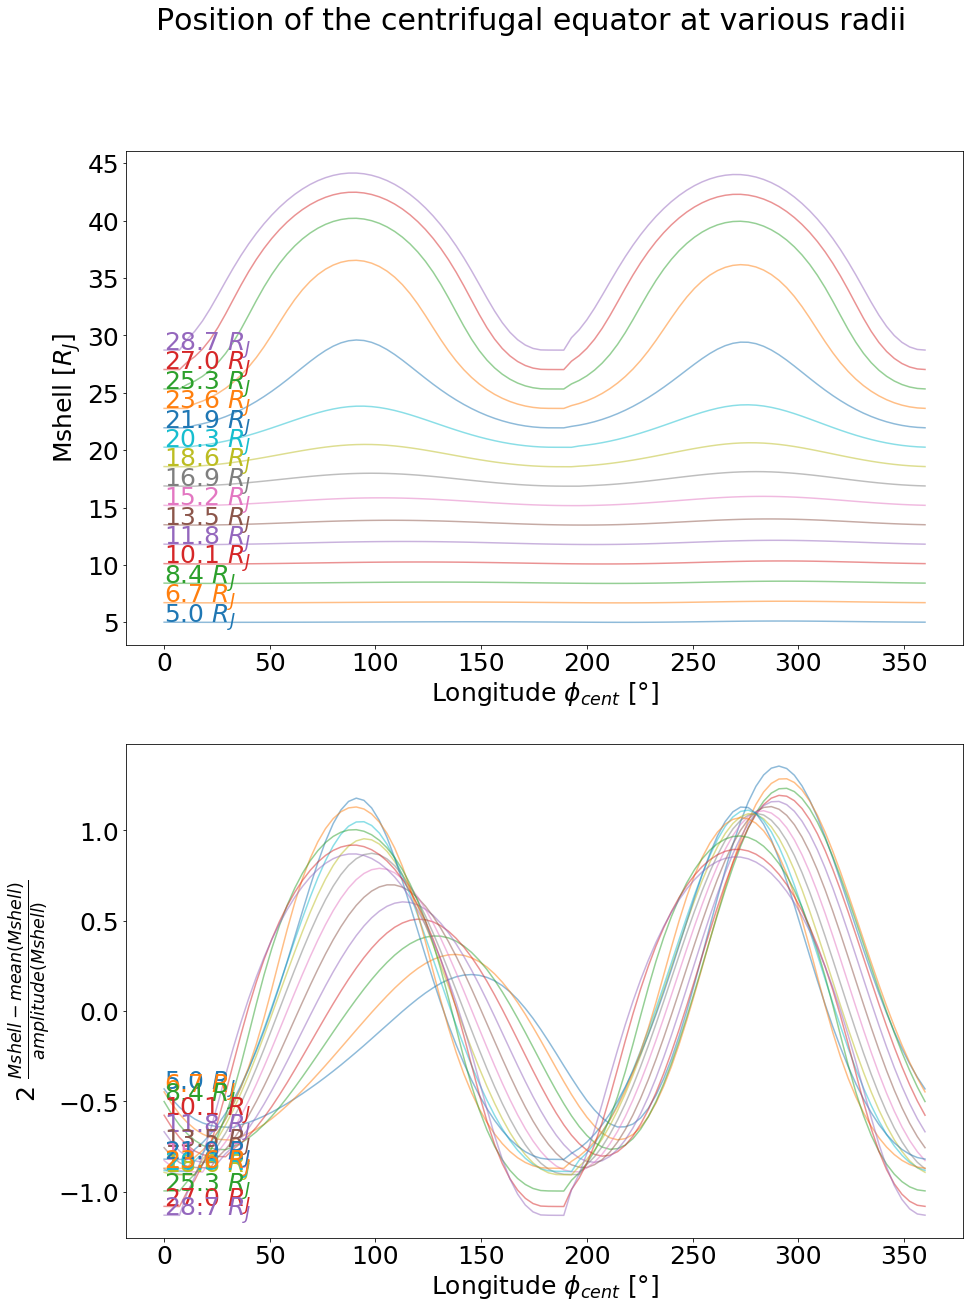

In [6]:
# Plot Mshell VS longitude
plt.rcParams.update({'font.size': 25})
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(211)
axmodify = fig.add_subplot(212)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for k in range(0, npoints[1], npoints[1]//15):
    r = radiis[0, k]
    mss = mshells[:, k]
    mssplot = 2*(mss-np.mean(mss))/(np.max(mss)-np.min(mss))
    p = ax.plot(longitudes[:, k], mss, alpha=0.5)
    ax.text(longitudes[0, k], mss[0], "{:.1f} $R_J$".format(r), color=p[0].
    get_color())
    axmodify.plot(longitudes[:, k], mssplot, alpha=0.5, color=p[0].get_color())
    axmodify.text(longitudes[0, k], mssplot[0], "{:.1f} $R_J$".format(r),color=p[0].get_color())
    
plt.setp([ax, axmodify], xlabel="Longitude $\phi_{cent}$ [°]")
ax.set_ylabel("Mshell [$R_J$]")
axmodify.set_ylabel(r"2 $\frac{Mshell - mean(Mshell)}{amplitude(Mshell)}$")
fig.suptitle("Position of the centrifugal equator at various radii")
plt.show()

From the second figure, it appears that, even though the dependance of Mshell on $\phi_{cent}$ seems to become sinusoidal at high radii, that is not at all the case at lower radii (e.g. $r_{cent} = 5 R_J$). It could eventually be necessary to include an affine amplitude, which parameters would depend on r, as well as a variable delay with $\phi_{cent}$. This is what we explore in the following.

Fitting to data : delay, slope, amplitude offset, total offset

 At 5.0 $R_J$
Values =  ['18.65', '-0.00', '0.05', '5.01']
Variance = ['3.01e+01', '4.95e-09', '1.90e-04', '2.33e-05']

 At 7.5 $R_J$
Values =  ['26.97', '-0.00', '0.11', '7.57']
Variance = ['3.19e+01', '9.57e-09', '3.93e-04', '4.95e-05']

 At 10.1 $R_J$
Values =  ['23.21', '-0.00', '0.22', '10.13']
Variance = ['1.67e+01', '2.26e-08', '9.19e-04', '1.13e-04']

 At 12.6 $R_J$
Values =  ['16.61', '-0.00', '0.46', '12.68']
Variance = ['9.22e+00', '6.43e-08', '2.52e-03', '3.06e-04']

 At 15.2 $R_J$
Values =  ['10.72', '-0.01', '0.97', '15.23']
Variance = ['6.45e+00', '2.27e-07', '8.57e-03', '1.05e-03']

 At 17.7 $R_J$
Values =  ['6.35', '-0.01', '2.08', '17.80']
Variance = ['5.58e+00', '9.74e-07', '3.58e-02', '4.45e-03']

 At 20.3 $R_J$
Values =  ['3.54', '-0.03', '4.88', '20.38']
Variance = ['5.55e+00', '5.52e-06', '1.99e-01', '2.51e-02']

 At 22.8 $R_J$
Values =  ['2.21', '-0.08', '14.12', '22.83']
Variance = ['6.10e+00', '5.

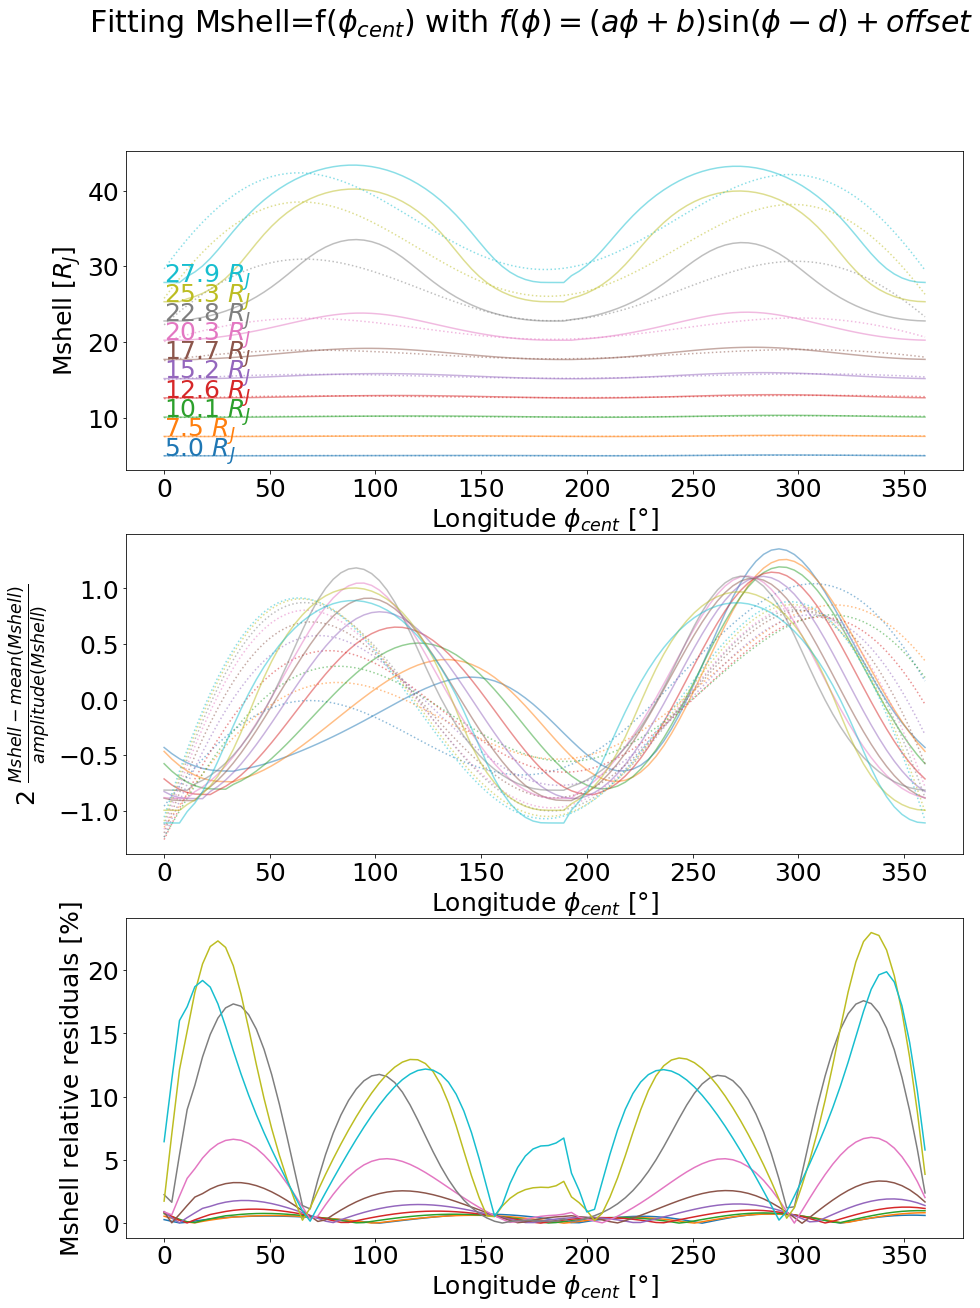

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
plt.setp(axs, xlabel="Longitude $\phi_{cent}$ [°]")
axs[0].set_ylabel("Mshell [$R_J$]")
axs[1].set_ylabel(r"2 $\frac{Mshell - mean(Mshell)}{amplitude(Mshell)}$")
axs[2].set_ylabel("Mshell relative residuals [%]")
fig.suptitle("Fitting Mshell=f($\phi_{cent}$) with $f(\phi)=(a\phi + b)\sin(\phi-d)+offset$")

def fitfunc_long(longitude, delay, slope, offsetamplitude, offset):
    return np.sin(pi/180.*(longitude-delay))*(slope*longitude+offsetamplitude) + offset

argsoptlists = []

print("Fitting to data : delay, slope, amplitude offset, total offset")
for k in range(0, npoints[1], npoints[1]//10):
    r = radiis[0, k]
    mss = mshells[:, k]
    lons = longitudes[:, k]
    argsopt, _ = fitandplot(axs, fitfunc_long, lons, mss, np.array([50., 0., 1., np.mean(mss)]),
                            labelin="{:.1f} $R_J$".format(r),textloc_ind_offset=(0, 0.),
                            transformfunction=lambda x:2.*(x-np.mean(x))/(np.max(x)-np.min(x)))
    argsoptlists.append(argsopt)
    
plt.show()

As seen in the previous panel, the suggested model does not properly fits the Mshell VS longitude relation. Especially, the locations of the peak values are not well reproduced by the simple affine modulated sine function. Hence I try to improve it by adding a additional variable frequency for the sine modulation in the next panels.

Fitting to data : delay, slope, amplitude offset, total offset, frequency

 At 5.0 $R_J$
Values =  ['113.31', '-0.00', '0.06', '5.03', '0.03']
Variance = ['4.11e+00', '3.53e-10', '1.45e-05', '1.70e-06', '8.23e-08']

 At 7.5 $R_J$
Values =  ['110.06', '-0.00', '0.09', '7.60', '0.03']
Variance = ['7.28e+00', '1.03e-09', '4.17e-05', '5.15e-06', '1.37e-07']

 At 10.1 $R_J$
Values =  ['102.95', '-0.00', '0.13', '10.19', '0.03']
Variance = ['1.74e+01', '3.61e-09', '1.43e-04', '2.02e-05', '2.88e-07']

 At 12.6 $R_J$
Values =  ['36.27', '-0.00', '0.44', '12.72', '0.02']
Variance = ['1.17e+01', '3.44e-08', '1.31e-03', '1.88e-04', '1.04e-07']

 At 15.2 $R_J$
Values =  ['29.26', '-0.01', '0.97', '15.32', '0.02']
Variance = ['6.03e+00', '1.01e-07', '3.75e-03', '5.33e-04', '5.78e-08']

 At 17.7 $R_J$
Values =  ['25.28', '-0.01', '2.11', '17.98', '0.02']
Variance = ['4.40e+00', '3.80e-07', '1.38e-02', '1.97e-03', '4.41e-08']

 At 20.3 $R_J$
Values =  ['22.85', '-0.03', '4.99', '20.79', '0.02']
Varia

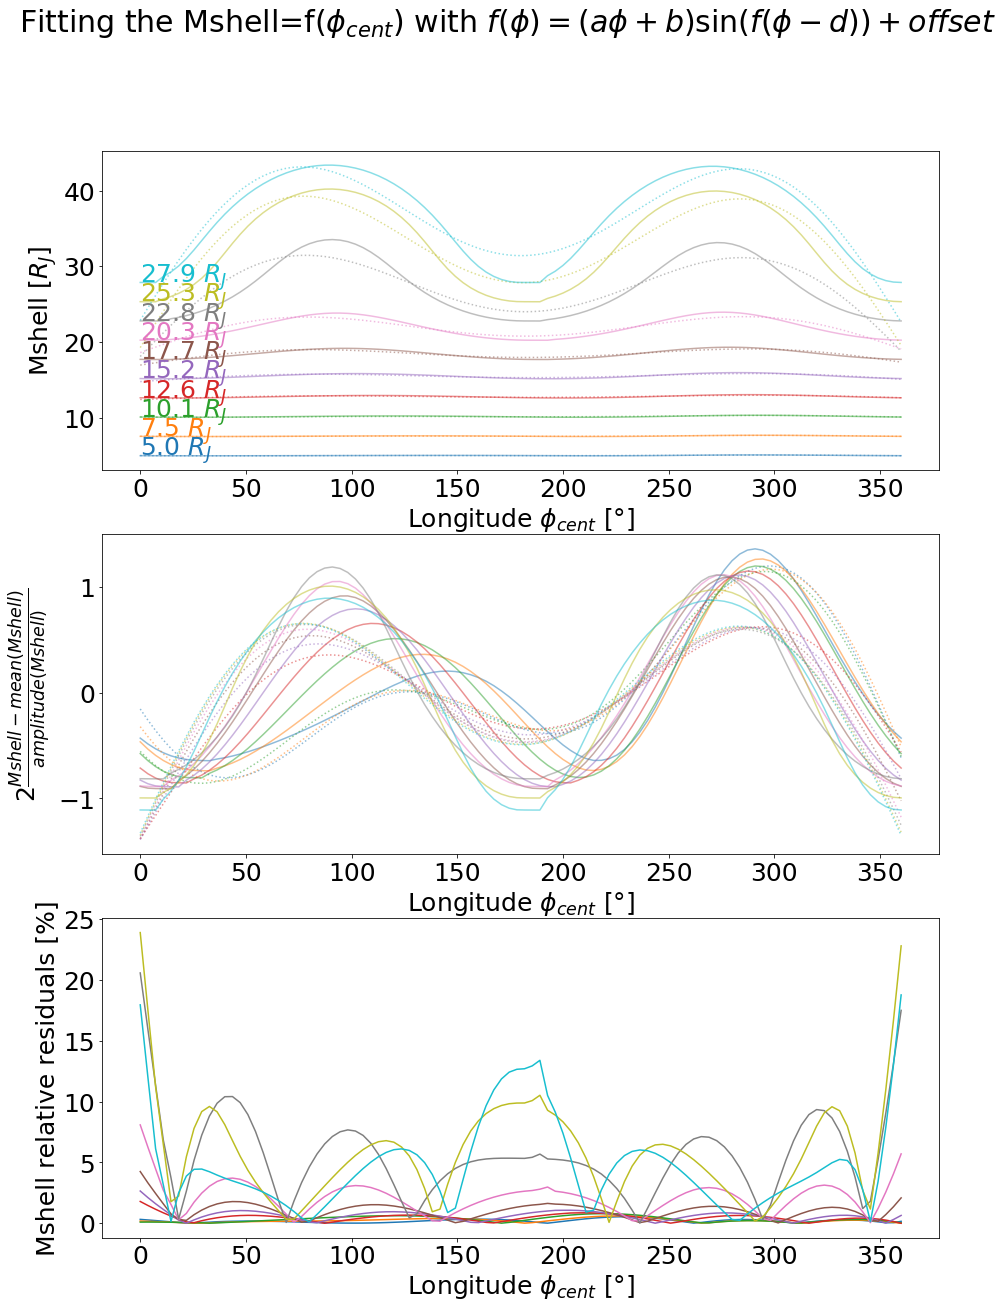

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
plt.setp(axs, xlabel="Longitude $\phi_{cent}$ [°]")
axs[0].set_ylabel("Mshell [$R_J$]")
axs[1].set_ylabel(r"2$\frac{Mshell - mean(Mshell)}{amplitude(Mshell)}$")
axs[2].set_ylabel("Mshell relative residuals [%]")
fig.suptitle("Fitting the Mshell=f($\phi_{cent}$) with $f(\phi)=(a\phi + b)\sin(f(\phi-d))+offset$")

def fitfunc_long(longitude, delay, slope, offsetamplitude, offset, frequency):
    return np.sin(frequency*(longitude-delay))*(slope*longitude+offsetamplitude) + offset
             
argsoptlists2 = []
print("Fitting to data : delay, slope, amplitude offset, total offset, frequency")
for k, args0 in zip(range(0, npoints[1], npoints[1]//10), argsoptlists):
    r = radiis[0, k]
    mss = mshells[:, k]
    lons = longitudes[:, k]
    argsopt, _ = fitandplot(axs, fitfunc_long, lons, mss, np.append(args0, [pi/180.]),
                            labelin="{:.1f} $R_J$".format(r),textloc_ind_offset=(0, 0.), 
                            transformfunction=lambda x:2.*(x-np.mean(x))/(np.max(x)-np.min(x)))
    argsoptlists2.append(argsopt)
plt.show()

#### Mshell VS radius

The next cell intend to tweak the Mshell VS $r_{cent}$ data in order to extract potential tendances. A first subfigure simply shows the variation of Mshell with radius, at various fixed longitudes.

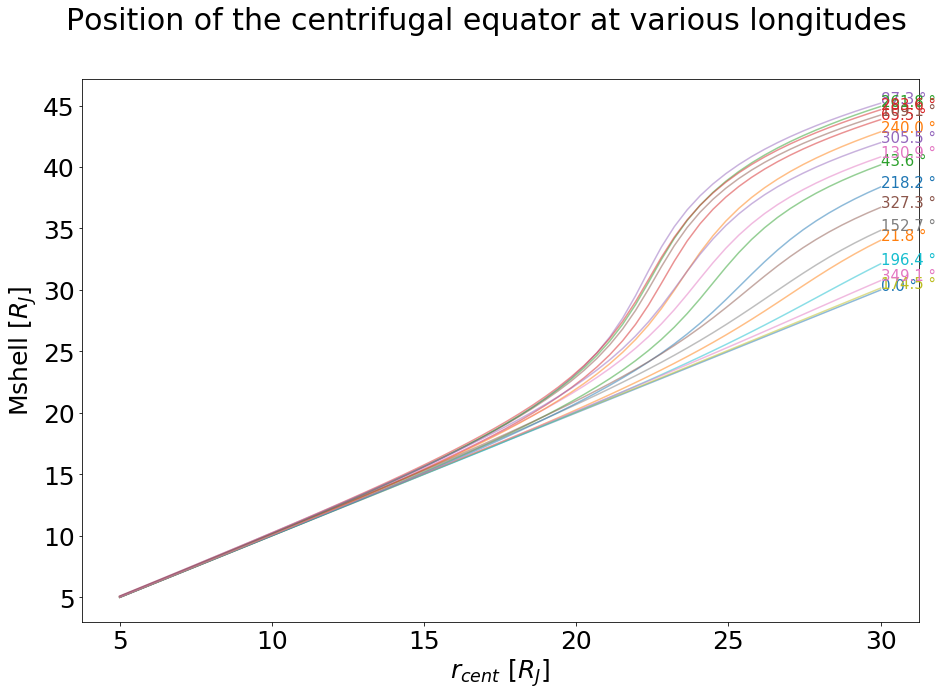

In [11]:
#plot radii
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
# axmodify = fig.add_subplot(212)
for k in range(0, npoints[0], npoints[0]//15):
    lon = longitudes[k, 0]
    mss = mshells[k]
    # mssplot = 2*(mss-np.mean(mss))/(np.max(mss)-np.min(mss))

    p = ax.plot(radiis[k], mss, alpha=0.5)
    ax.text(radiis[k, -1], mss[-1], "{:.1f} °".format(lon), color=p[0].get_color(), fontsize=15)

plt.setp([ax], xlabel="$r_{cent}$ [$R_J$]")
ax.set_ylabel("Mshell [$R_J$]")
axmodify.set_ylabel("2(Mshell - mean(Mshell))/amplitude(Mshell)")
fig.suptitle("Position of the centrifugal equator at various longitudes")
plt.show()

As seen in the figure above, there seems to be a clear affine trend between Mshell and $r_{cent}$. In the
following, we fit an affine function to the first half of rcent range, which seems dominated by this
trend. We then study the remaining dependance.

Fitting to data : slope, offset

 At 0.0 °
Values =  ['1.00', '-0.00']
Variance = ['3.30e-08', '2.46e-06']

 At 36.4 °
Values =  ['1.00', '-0.02']
Variance = ['1.53e-07', '1.14e-05']

 At 72.7 °
Values =  ['1.02', '-0.11']
Variance = ['2.62e-06', '1.96e-04']

 At 109.1 °
Values =  ['1.03', '-0.15']
Variance = ['3.50e-06', '2.61e-04']

 At 145.5 °
Values =  ['1.02', '-0.07']
Variance = ['4.37e-07', '3.26e-05']

 At 181.8 °
Values =  ['1.00', '0.02']
Variance = ['6.92e-08', '5.17e-06']

 At 218.2 °
Values =  ['1.00', '-0.02']
Variance = ['1.52e-07', '1.14e-05']

 At 254.5 °
Values =  ['1.02', '-0.09']
Variance = ['3.03e-06', '2.26e-04']

 At 290.9 °
Values =  ['1.04', '-0.10']
Variance = ['3.71e-06', '2.77e-04']

 At 327.3 °
Values =  ['1.02', '-0.05']
Variance = ['3.31e-07', '2.48e-05']


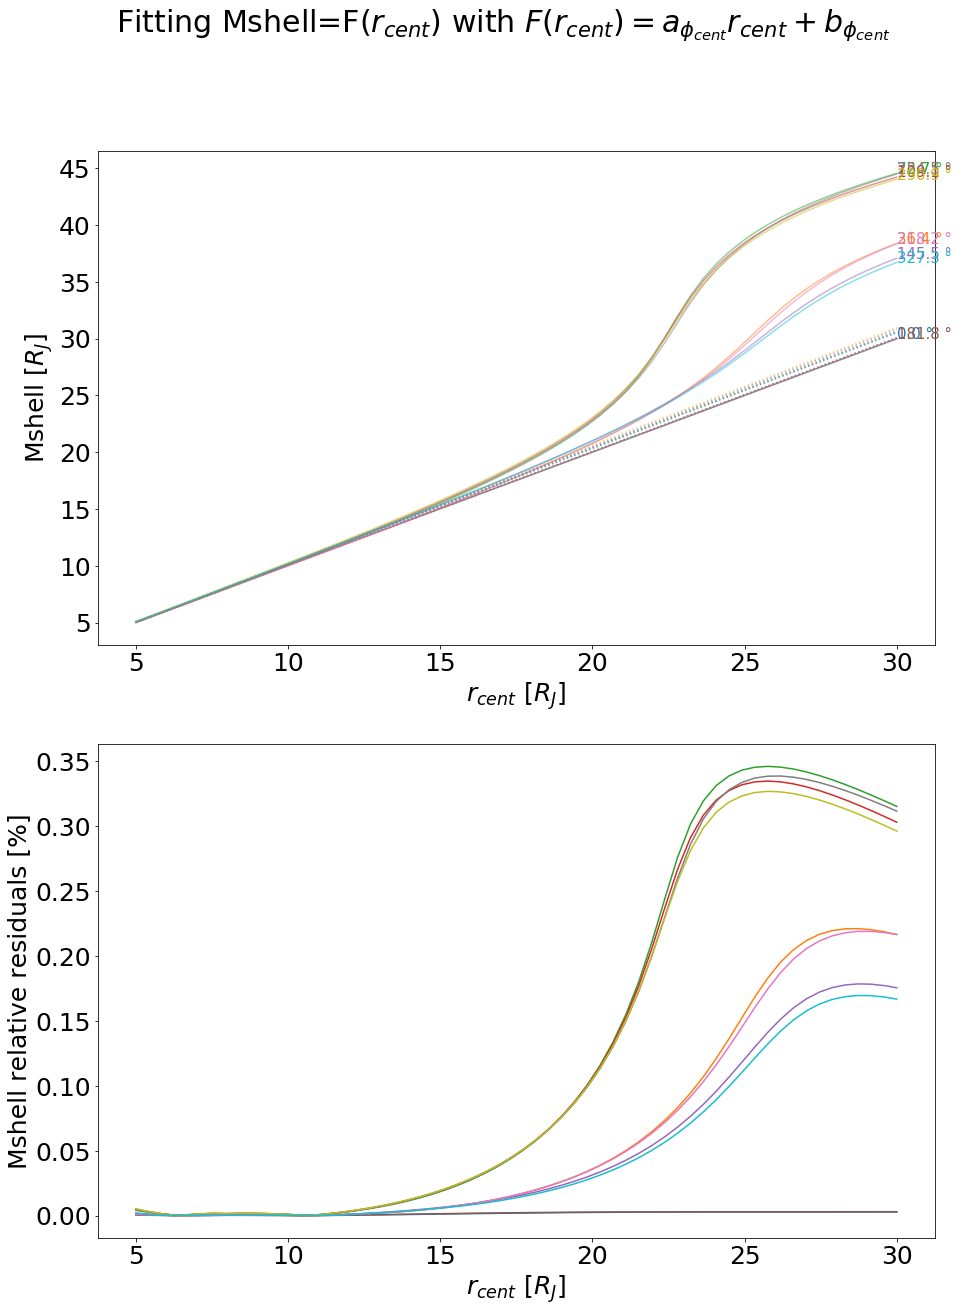

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15, 20))
plt.setp(axs, xlabel="$r_{cent}$ [$R_J$]")
axs[0].set_ylabel("Mshell [$R_J$]")
axs[1].set_ylabel("Mshell relative residuals [%]")
fig.suptitle(r"Fitting Mshell=F($r_{cent}$) with $F(r_{cent}) = a_{\phi_{cent}}r_{cent} + b_{\phi_{cent}}$")

def fitfunc_raffine(r, a, b):
    return a*r + b

argsoptlistraffines = []
print("Fitting to data : slope, offset")
for k in range(0, npoints[0], npoints[0]//10):
    rs = radiis[k]
    lon = longitudes[k, 0]
    mss = mshells[k]
    
    fitindices = np.where(rs<12.)[0]
    res = curve_fit(fitfunc_raffine, rs[fitindices], mss[fitindices], p0=np.array([1., 0.1]))
    argsopt = res[0]
    cov = res[1]
    mssmodel = fitfunc_raffine(rs, *argsopt)
    argsoptlistraffines.append(argsopt)
    
    print("\n At {:.1f} °".format(lon))
    print("Values = ", ["{:.2f}".format(arg) for arg in argsopt])
    print("Variance =", ["{:.2e}".format(cov[i, i]) for i in range(argsopt.size)])
    
    p = axs[0].plot(rs, mss, alpha=0.5)
    axs[0].plot(rs, mssmodel, alpha=0.5, color=p[0].get_color(), linestyle=":")
    axs[0].text(rs[-1], mss[-1], "{:.1f} °".format(lon), color=p[0].get_color(), fontsize=15)
    axs[1].plot(rs, np.abs(mss-mssmodel)/mss, color=p[0].get_color())
    
plt.show()

We fit the residuals with a hyperbolic tangent function, building on *Phipps et Bagenal (2021)*.

Fitting to data : amplitude, spatial rate, spatial delay, offset

 At 0.0 °
Values =  ['-0.05', '0.14', '19.17', '-0.04']
Variance = ['1.11e-06', '3.62e-05', '2.09e-02', '3.81e-07']

 At 36.4 °
Values =  ['4.46', '0.29', '24.83', '4.53']
Variance = ['2.81e-03', '5.66e-05', '3.47e-03', '2.33e-03']

 At 72.7 °
Values =  ['7.16', '0.40', '22.25', '7.33']
Variance = ['2.70e-03', '1.26e-04', '1.57e-03', '2.23e-03']

 At 109.1 °
Values =  ['6.86', '0.40', '22.21', '7.03']
Variance = ['2.75e-03', '1.30e-04', '1.77e-03', '2.26e-03']

 At 145.5 °
Values =  ['3.61', '0.26', '25.05', '3.65']
Variance = ['2.42e-03', '4.20e-05', '4.99e-03', '2.01e-03']

 At 181.8 °
Values =  ['-0.04', '0.16', '17.57', '-0.04']
Variance = ['8.86e-07', '6.50e-05', '2.21e-02', '3.41e-07']

 At 218.2 °
Values =  ['4.53', '0.28', '25.07', '4.59']
Variance = ['3.01e-03', '4.15e-05', '3.70e-03', '2.51e-03']

 At 254.5 °
Values =  ['7.07', '0.38', '22.38', '7.22']
Variance = ['2.66e-03', '1.00e-04', '1.61e-03', '2.16e-03']

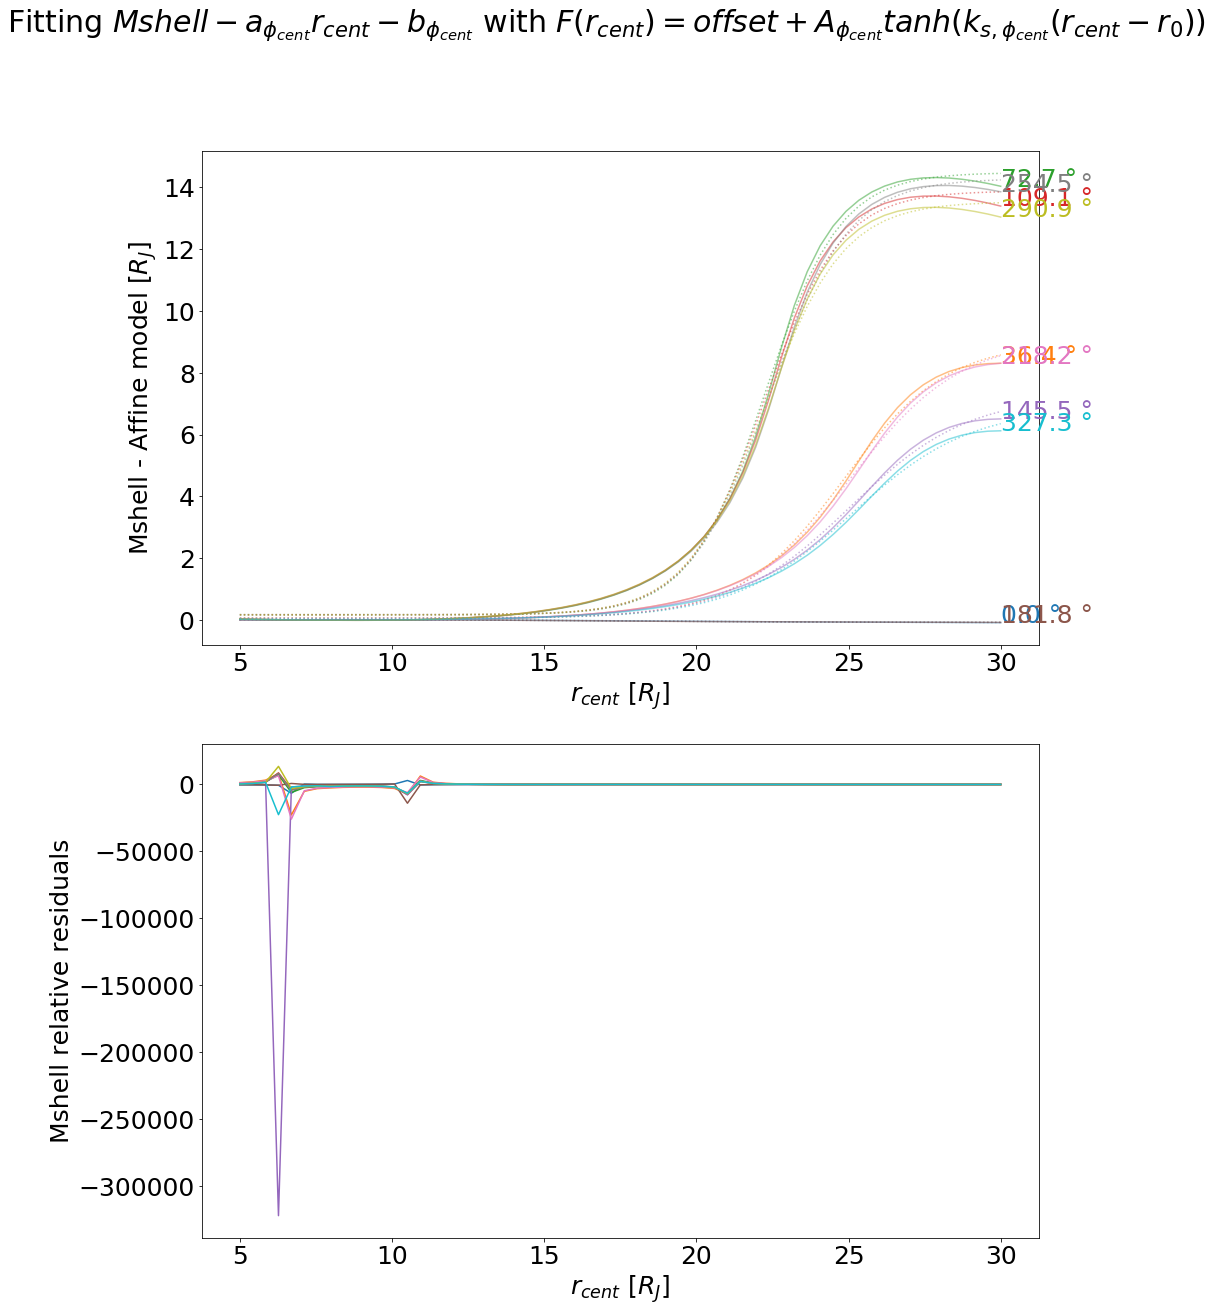

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15, 20))
plt.setp(axs, xlabel="$r_{cent}$ [$R_J$]")
axs[0].set_ylabel("Mshell - Affine model [$R_J$]")
axs[1].set_ylabel("Mshell relative residuals")
fig.suptitle(r"Fitting $Mshell - a_{\phi_{cent}} r_{cent} - b_{\phi_{cent}}$ "\
             "with $F(r_{cent}) = offset + A_{\phi_{cent}} tanh(k_{s,\phi_{cent}} (r_{cent} - r_0))$")

def fitfunc_rrest(r, amplitude, kspat, rdelay, offset):
    return offset + amplitude * np.tanh(kspat*(r-rdelay))

argsoptlistrests = []
print("Fitting to data : amplitude, spatial rate, spatial delay, offset")
for k, args0affine in zip(range(0, npoints[0], npoints[0]//10),argsoptlistraffines):
    rs = radiis[k]
    lon = longitudes[k, 0]
    mss = mshells[k] - fitfunc_raffine(rs, *args0affine)
    argsopt, _ = fitandplot(axs, fitfunc_rrest, rs, mss, np.array([1., 0.5, 12., np.mean(mss)]),
                            labelin="{:.1f} °".format(lon),textloc_ind_offset=(-1, 0.),
                            transformfunction=None)
    argsoptlistrests.append(argsopt)
plt.show()

Fitting to data : slope, offset, amplitude, spatial rate, spatial delay


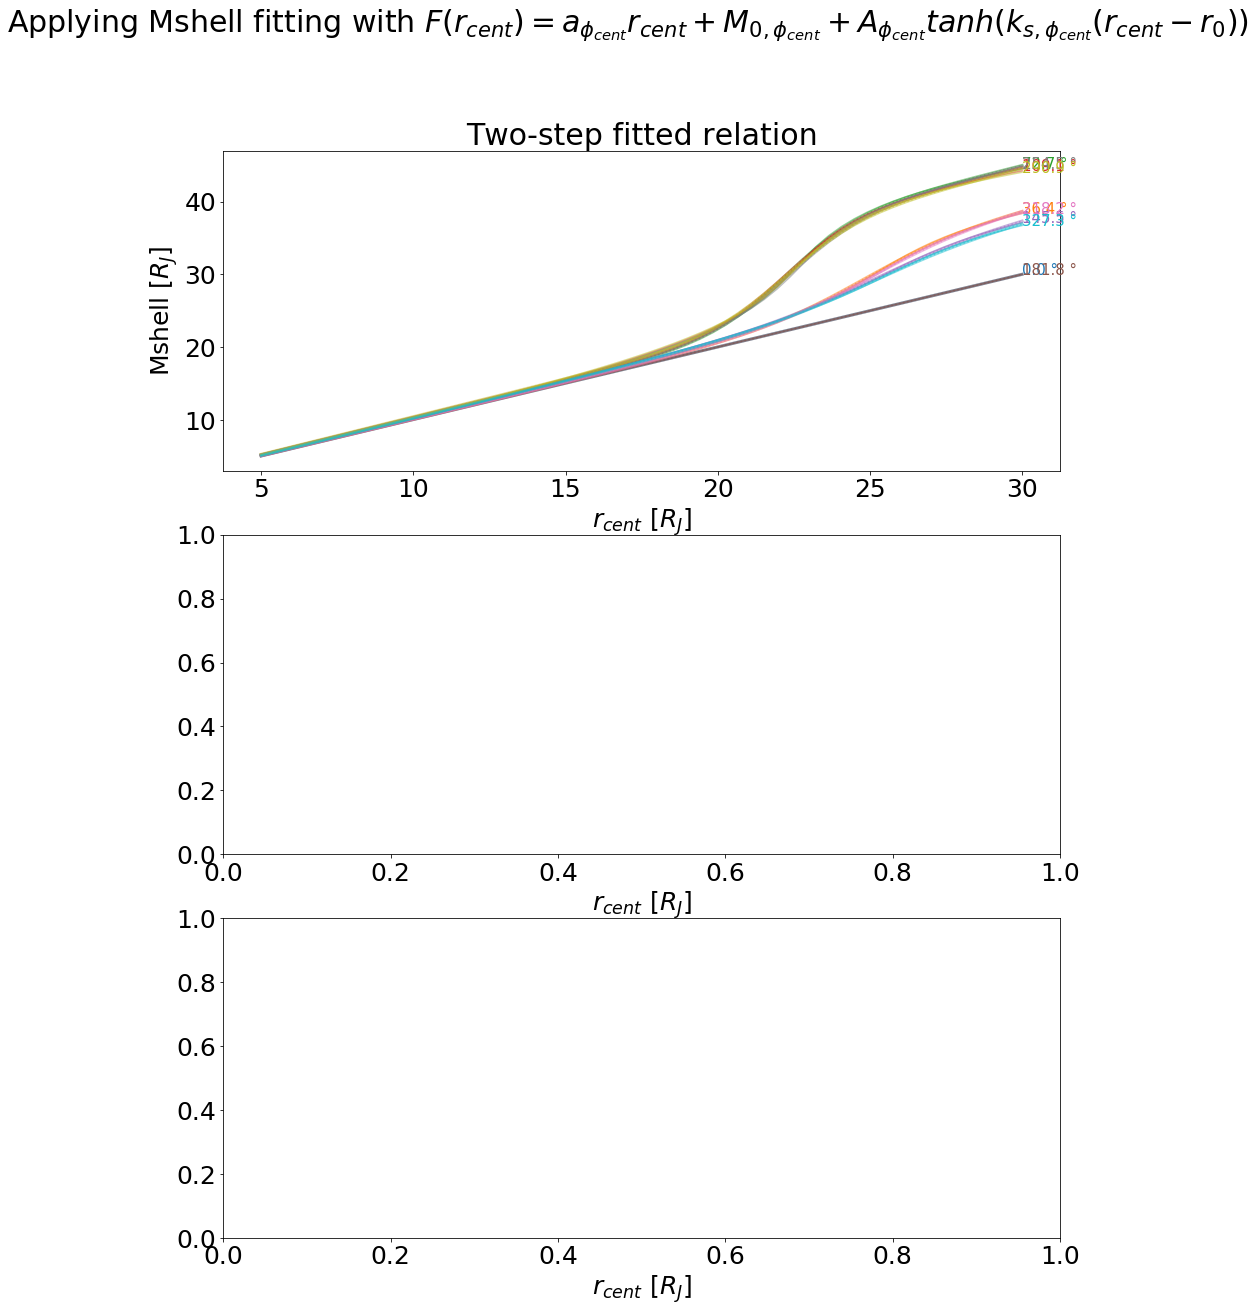

In [20]:
# Plotting the total model Mshell = F(r_cent) and intending a total fit
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
plt.setp(axs, xlabel="$r_{cent}$ [$R_J$]")
axs[0].set_ylabel("Mshell [$R_J$]")
axs[0].set_title("Two-step fitted relation")
# axs[1].set_ylabel("Mshell [$R_J$]")
# axs[1].set_title("Direct fitted relation")
# axs[2].set_ylabel("Relative residuals")
fig.suptitle(r"Applying Mshell fitting with $F(r_{cent}) = a_{\phi_{cent}} r_{cent} + M_{0,\phi_{cent}} "\
             "+ A_{\phi_{cent}} tanh(k_{s,\phi_{cent}} (r_{cent} - r_0))$")

def fitfunc_rglobal(r, a, M0, amplitude, kspat, rdelay):
    return a*r + M0 + amplitude * np.tanh(kspat*(r-rdelay))
# def fitfunc_rglobal(r, a, M0, amplitude, kspat, rdelay, offset):
#return fitfunc_raffine(r, a, M0) + fitfunc_rrest(r, amplitude, kspat, rdelay, offset)

print("Fitting to data : slope, offset, amplitude, spatial rate, spatial delay")
for k, args0affine, args0rests in zip(range(0, npoints[0], npoints[0]//10),argsoptlistraffines, argsoptlistrests):
    rs = radiis[k]
    lon = longitudes[k, 0]
    mss = mshells[k]
    mssmodel0 = fitfunc_raffine(rs, *args0affine) + fitfunc_rrest(rs, *args0rests)
    
    p = axs[0].plot(rs, mss, alpha=0.5)
    axs[0].plot(rs, mssmodel0, alpha=0.5, color=p[0].get_color(), linestyle=":")
    axs[0].text(rs[-1], mss[-1], "{:.1f} °".format(lon), color=p[0].get_color(), fontsize=15)
    args0 = np.append(np.array([args0affine[0], args0affine[-1]+args0rests[-1]]), args0rests[:-1])
    axs[0].plot(rs, fitfunc_rglobal(rs, *args0), color=p[0].get_color(), linewidth=3, alpha=0.5)
#     argsopt, _ = fitandplot(axs[1:], fitfunc_rglobal, rs, mss, args0, 
#                             labelin="{:.1f} °".format(lon), textloc_ind_offset=(-1, 0.), 
#                             transformfunction=None)

plt.show()

The latest fitting attempt statisfyingly reproduce the relation between rcent and Mshell at all
longitudes. In the following, we apply it at all longitude. This will allow us to study the variation
of the fitting parameters on longitude and built a global function to account for the dependance of
Mshell on both $r_{cent}$ and $\phi_{cent}$.

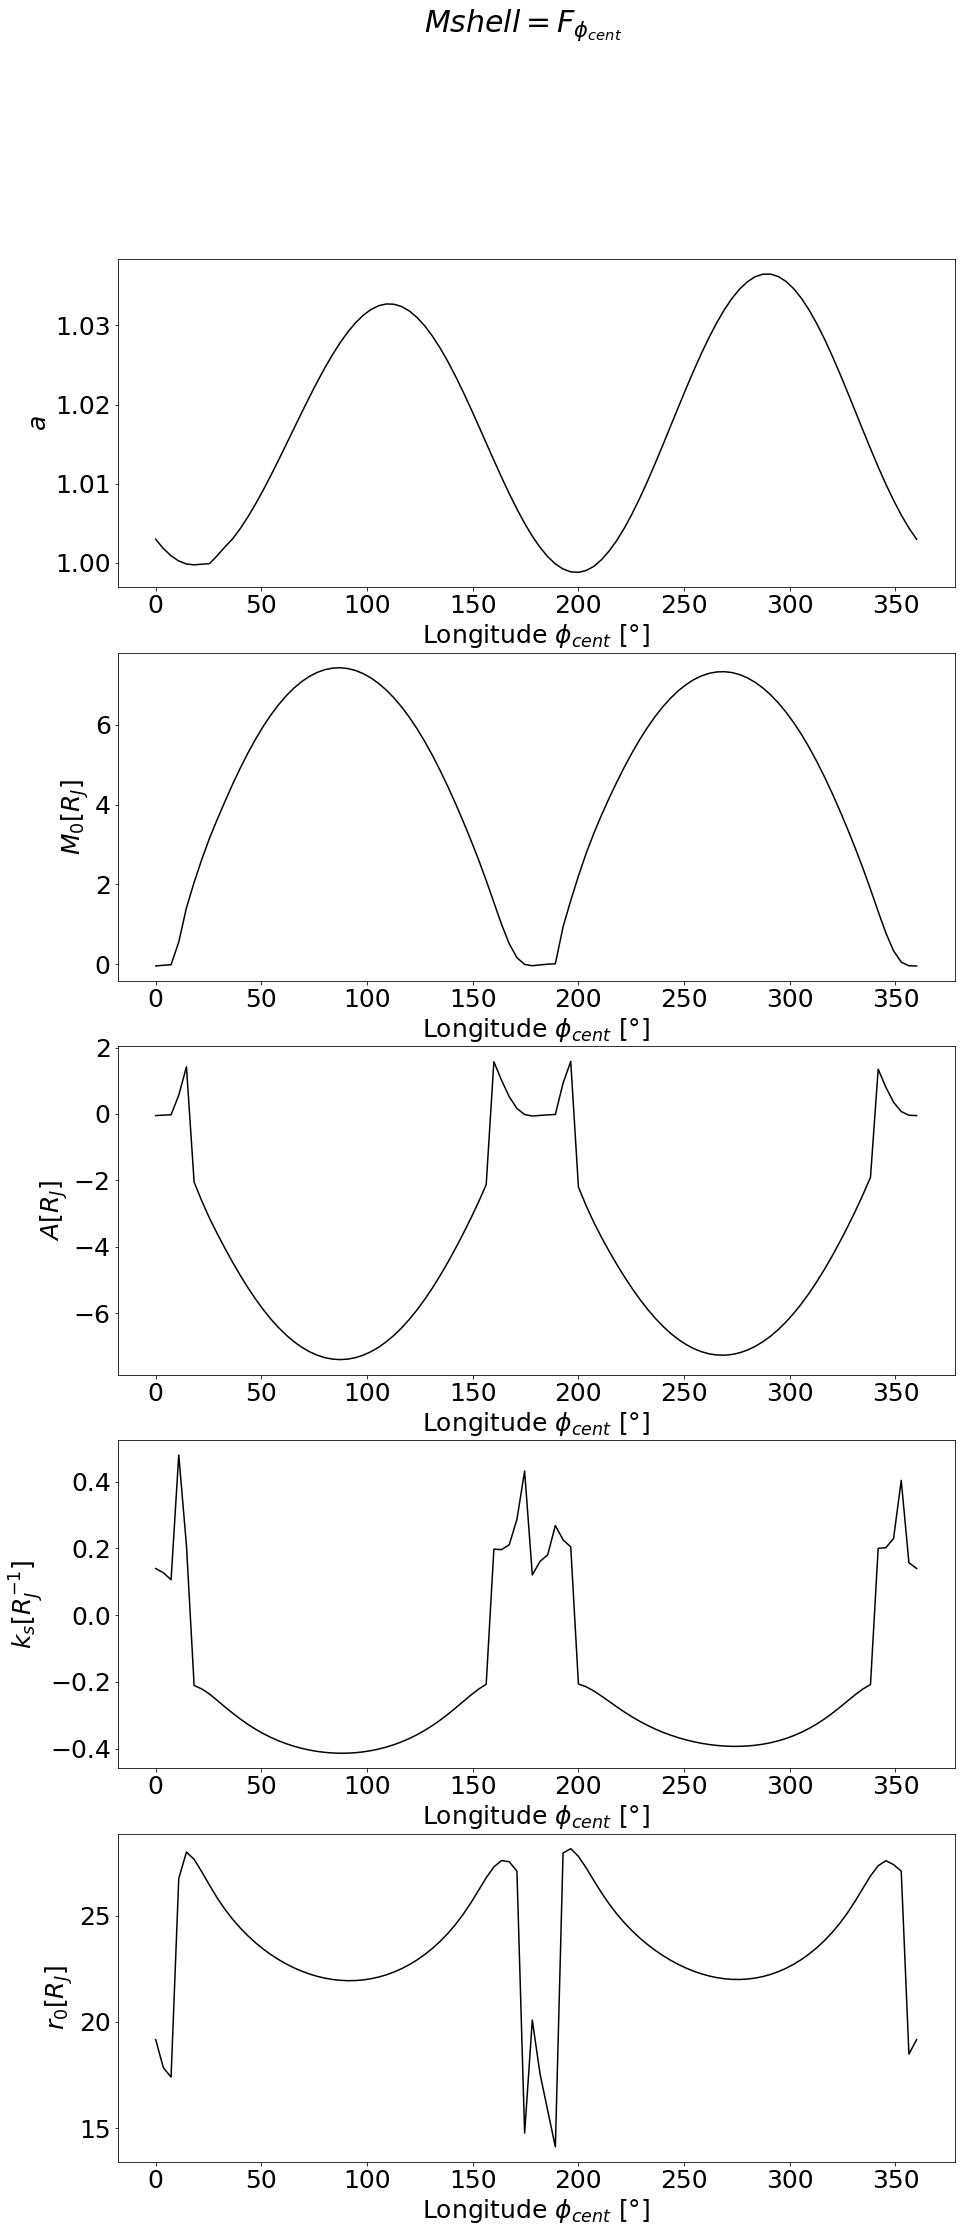

In [18]:
args0rlists = []
argsoptlists = []

for k in range(0, npoints[0]):
    rs = radiis[k]
    lon = longitudes[k, 0]
    mss = mshells[k]
    
    # pre-fit analysis : compute reasonable parameters to start the global fit
    fitindices = np.where(rs<12.)[0]
    resaffine, _ = curve_fit(fitfunc_raffine, rs[fitindices], mss[fitindices], p0=np.array([1., 0.1]))
    mssrests = mss - fitfunc_raffine(rs, *resaffine)
    resrest, _ = curve_fit(fitfunc_rrest, rs, mssrests, p0=np.array([1., 0.5, 22., np.mean(mss)]))
    args0 = np.append(np.array([resaffine[0], resaffine[-1]+resrest[-1]]), resrest[:-1])
    args0rlists.append(args0[:])
    
    # global fit, starting from the results of the pre-fit analysis
    # argsoptr, _ = curve_fit(fitfunc_rglobal, rs, mss, p0=args0)
    # argsoptlists.append(argsoptr)
args0rlists = np.array(args0rlists)
num_args= args0rlists[0].size


fig, axs = plt.subplots(num_args, 1, figsize=(15, 7*num_args))
fig.suptitle("$Mshell = F_{\phi_{cent}}}(r) = a_{\phi_{cent}} r_{cent} + M_{0,\phi_{cent}} "\
             "+ A_{\phi_{cent}} tanh(k__{s,\phi_{cent}} (r_{cent} - r_0))$")
plt.setp(axs, xlabel="Longitude $\phi_{cent}$ [°]")

lons = longitudes[:, 0]
for k, (argsopt, label) in enumerate(zip(np.transpose(args0rlists),["a", "M_0 [R_J]", "A [R_J]", "k_s [R_J^{-1}]", "r_0 [R_J]"])):
    axs[k].plot(lons, argsopt, color="black")
    axs[k].set_ylabel("${}$".format(label))
    
plt.show()